In [1]:
from dependencies import *

userdata = pd.read_csv('data/yelp/user.csv', low_memory=False)
uid2num = {k:v for k,v in zip(userdata['user_id'].values,range(len(userdata['user_id'].values)))}
num2uid = {k:v for v,k in uid2num.items()}

udata = pickle.load(open( "udata.p", "rb" ))
adj = {uid2num[k]:[uid2num[x] for x in v.split(', ') if x in uid2num] for k,v in zip(udata['user_id'].values,udata['friends'].values)}


Using TensorFlow backend.


In [2]:
components = pickle.load(open( "graph_components_apr29.p", "rb" ))
#Get the training and the test connected component
gc = components[0]

def giveagraph(gc,start=0,end=10000):
	temp = nx.Graph()
	temp.add_nodes_from(list(gc.nodes)[start:end])
	temp.add_edges_from([(i,j) for i in temp.nodes for j in gc[i] if j in temp.nodes ])
	return max(nx.connected_component_subgraphs(temp), key=len)

#traing = giveagraph(gc)
#testg = giveagraph(gc,10000,20000)



In [3]:
def giveagraph_nodes(gc,nodes):
	temp = nx.Graph()
	temp.add_nodes_from(nodes)
	temp.add_edges_from([(i,j) for i in nodes for j in gc[i] if j in nodes ])
	return max(nx.connected_component_subgraphs(temp), key=len)

import random
nodes  = list(gc.nodes)[0:20000]
random.Random(4).shuffle(nodes)
traing = giveagraph_nodes(gc,nodes[:10000])
testg = giveagraph_nodes(gc,nodes[10000:])


In [4]:
len(testg.nodes)

7151

In [5]:
def sample_edges(g,possize=100,negsize=100,full = False):
    negexamples = list(nx.non_edges(g))
    totaledges = len(g.edges())
    if full:
        posset = np.array(g.edges())
        negsize = totaledges
    else:
        np.random.seed(4)
        posset = np.random.choice(np.array(g.edges()), possize)
    np.random.seed(4)
    negindices = np.random.choice(range(len(negexamples)), negsize)
    negset = np.array(negexamples)[negindices]
    return posset,negset

postrainset, negtrainset = sample_edges(traing, full = True)
postestset, negtestset = sample_edges(testg, full = True)

In [6]:
len(postestset)

71839

In [7]:
ids  = udata.to_numpy()[:,[0]]
features = udata.to_numpy()[:,[2,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21]]
uid2feat = dict(zip(ids.reshape(-1),features))

In [8]:
uid2fset = {a:set(b.split(', ')) for a,b in zip(udata['user_id'].values,udata['friends'].values)}
uid2bidset = {a:b for a,b in zip(udata['user_id'].values,udata['bidset'].values)}
uid2cityset = {a:b for a,b in zip(udata['user_id'].values,udata['cityset'].values)}

def givenumcommon(uid2set,uid1,uid2):
    a = uid2set[uid1]
    b = uid2set[uid2]
    return len(a.intersection(b))

def givenumunion(uid2set,uid1,uid2):
    a = uid2set[uid1]
    b = uid2set[uid2]
    return len(a.union(b))

In [9]:
def givejaccard(uidset,uid1,uid2):
    a = givenumcommon(uidset,uid1,uid2)
    b = givenumunion(uidset,uid1,uid2)
    return np.round((a*1.0)/(b*1.0),2)

def giveprefattach(uid2set,uid1,uid2):
    a = uid2set[uid1]
    b = uid2set[uid2]
    return (len(a) * len(b))

In [10]:
def giveedgefeats(pairlist,cfriends=True,cbids=True,ccities= True):
    X = []
    for p in pairlist:
        id0 = num2uid[p[0]]
        id1 = num2uid[p[1]]
        feats = []
        if cfriends:
            feats.append(givenumcommon(uid2fset,id0,id1))
        if cbids:
            feats.append(givenumcommon(uid2bidset,id0,id1))
        if ccities:
            feats.append(givenumcommon(uid2cityset,id0,id1))
        X.append(feats)
    return np.array(X)

def giveedgefeats_jaccard(pairlist):
    X = []
    for p in pairlist:
        id0 = num2uid[p[0]]
        id1 = num2uid[p[1]]
        feats = []
        feats.append(givejaccard(uid2fset,id0,id1))
        feats.append(givejaccard(uid2bidset,id0,id1))
        feats.append(givejaccard(uid2cityset,id0,id1))
        X.append(feats)
    return np.array(X)

def giveedgefeats_prefattach(pairlist):
    X = []
    for p in pairlist:
        id0 = num2uid[p[0]]
        id1 = num2uid[p[1]]
        feats = []
        feats.append(giveprefattach(uid2fset,id0,id1))
        feats.append(giveprefattach(uid2bidset,id0,id1))
        feats.append(giveprefattach(uid2cityset,id0,id1))
        X.append(feats)
    return np.array(X)

def giveedgefeats_all(pairlist):
    X = []
    for p in pairlist:
        id0 = num2uid[p[0]]
        id1 = num2uid[p[1]]
        feats = []
        feats.append(givenumcommon(uid2fset,id0,id1))
        feats.append(givenumcommon(uid2bidset,id0,id1))
        feats.append(givenumcommon(uid2cityset,id0,id1))
        feats.append(givejaccard(uid2fset,id0,id1))
        feats.append(givejaccard(uid2bidset,id0,id1))
        feats.append(givejaccard(uid2cityset,id0,id1))
        X.append(feats)
    return np.array(X)

def giveedgedata(posset,negset,cfriends=True,cbids=True,ccities= True):
    X1  = giveedgefeats(posset,cfriends,cbids,ccities)
    X2  = giveedgefeats(negset,cfriends,cbids,ccities)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y

def giveedgedata_jaccard(posset,negset):
    X1  = giveedgefeats_jaccard(posset)
    X2  = giveedgefeats_jaccard(negset)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y

def giveedgedata_prefattach(posset,negset):
    X1  = giveedgefeats_prefattach(posset)
    X2  = giveedgefeats_prefattach(negset)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y


def giveedgedata_all(posset,negset):
    X1  = giveedgefeats_all(posset)
    X2  = giveedgefeats_all(negset)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y

def givenodefeats(pairlist):
    X = []
    for p in pairlist:
        id0 = num2uid[p[0]]
        id1 = num2uid[p[1]]
        X.append(np.concatenate([uid2feat[id0], uid2feat[id1]]))
    return np.array(X)

def givenodedata(posset,negset):
    X1  = givenodefeats(posset)
    X2  = givenodefeats(negset)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y


def givedatausingbothfeats(posset,negset):
    X1  = np.concatenate((giveedgefeats(posset),givenodefeats(posset)),1)
    X2  = np.concatenate((giveedgefeats(negset),givenodefeats(negset)),1)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y


def givedatausingbothfeats_jaccard(posset,negset):
    X1  = np.concatenate((giveedgefeats_jaccard(posset),givenodefeats(posset)),1)
    X2  = np.concatenate((giveedgefeats_jaccard(negset),givenodefeats(negset)),1)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y

def givefeats(pairlist):
    X = []
    for p in pairlist:
        id0 = p[0]
        id1 = p[1]
        X.append([id0,id1])
    return np.array(X)
    
def givedata(posset,negset):
    X1  = givefeats(posset)
    X2  = givefeats(negset)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y

In [11]:
def giveresults(Ytest,ytestpred):
    print("Accuracy ",np.round(accuracy_score(Ytest,ytestpred),3))
    print("Precision ",np.round(precision_score(Ytest,ytestpred),3))
    print("Recall ",np.round(recall_score(Ytest,ytestpred),3))
    print("F1 Score ",np.round(f1_score(Ytest,ytestpred),3))

In [12]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [13]:
from keras.models import Sequential
from keras.layers import Dense

from numpy.random import seed
seed(3)
from tensorflow import set_random_seed
set_random_seed(3)

In [14]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch.autograd import Variable
import random
random.seed(3)

In [15]:
class Encoder(nn.Module):
    """
    Encodes a node's using 'convolutional' GraphSage approach
    """
    def __init__(self, features, feature_dim, embed_dim, adj_lists, aggregator, n2mat, num_sample=10, base_model=None): 
        super(Encoder, self).__init__()
        self.features = features
        self.feat_dim = feature_dim
        self.adj_lists = adj_lists
        self.aggregator = aggregator
        self.num_sample = num_sample
        if base_model != None:
            self.base_model = base_model
        self.embed_dim = embed_dim
        self.weight = nn.Parameter(torch.FloatTensor(embed_dim, 2 * self.feat_dim))
        init.xavier_uniform_(self.weight)
        self.n2mat = n2mat
    def forward(self, nodes):
        """
        Generates embeddings for a batch of nodes.
        nodes     -- list of nodes
        """
        #print(self)
        neigh_feats = self.aggregator.forward(nodes, [set(self.adj_lists[int(node)]) for node in nodes], self.num_sample)
        #self_feats = self.features(torch.LongTensor([self.n2mat[x] for x in nodes]))
        self_feats = self.features[[self.n2mat[x] for x in nodes]]
        combined = torch.cat([self_feats, neigh_feats], dim=1)
        combined = F.relu(self.weight.mm(combined.t()))
        return combined

In [16]:
class MeanAggregator(nn.Module):
    """
    Aggregates a node's embeddings using mean of neighbors' embeddings
    """
    def __init__(self, features,n2mat): 
        super(MeanAggregator, self).__init__()
        self.features = features
        self.n2mat = n2mat
        
    def forward(self, nodes, to_neighs, num_sample=10):
        """
        nodes --- list of nodes in a batch
        to_neighs --- list of sets, each set is the set of neighbors for node in batch
        num_sample --- number of neighbors to sample. No sampling if None.
        """
        # Local pointers to functions (speed hack)
        #print(self)
        _set = set
        samp_neighs = to_neighs    
        unique_nodes_list = list(set.union(*samp_neighs))
        unique_nodes = {n:i for i,n in enumerate(unique_nodes_list)}
        mask = Variable(torch.zeros(len(samp_neighs), len(unique_nodes)))
        column_indices = [unique_nodes[n] for samp_neigh in samp_neighs for n in samp_neigh]   
        row_indices = [i for i in range(len(samp_neighs)) for j in range(len(samp_neighs[i]))]
        mask[row_indices, column_indices] = 1
        num_neigh = mask.sum(1, keepdim=True)
        mask = mask.div(num_neigh)
        #embed_matrix = self.features(torch.LongTensor([self.n2mat[x] for x in unique_nodes_list]))
        embed_matrix = self.features[[self.n2mat[x] for x in unique_nodes_list]]
        to_feats = mask.mm(embed_matrix)
        return to_feats

In [17]:
class SupervisedGraphSage(nn.Module):

    def __init__(self, enc):
        super(SupervisedGraphSage, self).__init__()
        self.enc = enc
        self.fc1 = nn.Linear(2*enc.embed_dim,24)
        self.fc2 = nn.Linear(24,16)
        self.fc3 = nn.Linear(16,2)
    def forward(self, nodes,test=False):
        self.enc = updateenc(self.enc,test)
        embeds1 = self.enc(nodes[:,0])
        embeds2 = self.enc(nodes[:,1])
        embeds = torch.cat([embeds1, embeds2], dim=0)
        hidden1 = F.relu(self.fc1(embeds.t()))
        hidden2 = F.relu(self.fc2(hidden1))
        return self.fc3(hidden2)

In [18]:
ttg = nx.Graph()
ttg.add_edges_from(list(traing.edges(data=True))+list(testg.edges(data=True)))
ttg.add_nodes_from(list(traing.nodes(data=True))+list(testg.nodes(data=True)))
feat_data = np.array([uid2feat[num2uid[x]] for x in ttg]).astype(dtype = 'float32')
nodes = list(ttg.nodes())
testnodes = list(testg.nodes())
trainnodes = list(traing.nodes())
n2mat = {i:j for j,i in enumerate(ttg.nodes)}
mat2n = {i:j for j,i in n2mat.items()}
features = torch.FloatTensor(feat_data)

In [67]:
agg1 = MeanAggregator(features,n2mat)
enc1 = Encoder(features, 18, 200, ttg, agg1,n2mat)
agg2 = MeanAggregator(enc1(nodes).t(), n2mat)
enc2 = Encoder(enc1(nodes).t(), 200, 200, ttg, agg2,n2mat, base_model=enc1)

In [68]:
def updateenc(enc,test=False):
    enc.features = enc1(nodes).t()
    enc.aggregator.features = enc1(nodes).t()
    return enc

In [69]:
graphsage = SupervisedGraphSage(enc2)
x,y = givedata(postrainset,negtrainset)
xtest,ytest = givedata(postestset,negtestset)

optimizer = torch.optim.Adam(filter(lambda p : p.requires_grad, graphsage.parameters()))
times = []
criterion = nn.CrossEntropyLoss()
for batch in range(200):
    batch_x = x[:200]
    batch_y = y[:200]
    x,y = shuffle(x,y)
    optimizer.zero_grad()
    loss = criterion(graphsage(batch_x),Variable(torch.LongTensor(batch_y)).squeeze())
    loss.backward(retain_graph=True)
    optimizer.step()
    if batch %5 == 0:
        print(batch, loss.data)

0 tensor(12.1194)
5 tensor(2.1481)
10 tensor(1.8680)
15 tensor(0.6402)
20 tensor(0.8914)
25 tensor(0.6949)
30 tensor(0.4631)
35 tensor(0.4281)
40 tensor(0.8112)
45 tensor(0.6108)
50 tensor(0.8303)
55 tensor(0.6601)
60 tensor(0.5160)
65 tensor(0.4429)
70 tensor(0.5097)
75 tensor(0.5132)
80 tensor(0.4438)
85 tensor(0.7127)
90 tensor(0.3345)
95 tensor(0.6316)
100 tensor(0.4373)
105 tensor(0.4390)
110 tensor(0.3215)
115 tensor(0.4320)
120 tensor(0.5834)
125 tensor(0.4152)
130 tensor(0.4387)
135 tensor(0.4835)
140 tensor(0.5142)
145 tensor(0.3479)
150 tensor(0.5260)
155 tensor(0.4975)
160 tensor(0.4927)
165 tensor(0.3684)
170 tensor(0.3698)
175 tensor(0.3411)
180 tensor(0.3636)
185 tensor(0.4347)
190 tensor(0.3988)
195 tensor(0.3137)


In [70]:
test_out = graphsage(xtest)
ypred = test_out.data.numpy().argmax(axis=1)
giveresults(ypred,ytest)

Accuracy  0.838
Precision  0.811
Recall  0.857
F1 Score  0.833


In [71]:
def giveencfeats(pairlist):
    X = []
    for p in pairlist:
        feats = []
        feats.append(id2enc[p[0]])
        feats.append(id2enc[p[1]])
        X.append(np.concatenate(feats))
    return np.array(X)

In [72]:
def giveencdata(posset,negset):
    X1  = giveencfeats(posset)
    X2  = giveencfeats(negset)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y

In [73]:
id2enc = {  mat2n[i]:j for i,j in enumerate(graphsage.enc(list(nodes)).detach().numpy().T)}

In [74]:
def giveencfeats_edge(pairlist):
    edgefeats = giveedgefeats_all(pairlist)
    X = []
    for p in pairlist:
        feats = []
        feats.append(id2enc[p[0]])
        feats.append(id2enc[p[1]])
        X.append(np.concatenate(feats))
    X=np.array(X)
    return np.concatenate([X,edgefeats],1)

In [75]:
def giveencdata_edge(posset,negset):
    X1  = giveencfeats_edge(posset)
    X2  = giveencfeats_edge(negset)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y

In [76]:
def giveencdata_node(posset,negset):
    X1  = np.concatenate((giveencfeats(posset),givenodefeats(posset)),1)
    X2  = np.concatenate((giveencfeats(negset),givenodefeats(negset)),1)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y

In [77]:
def givedatausingbothfeats_enc(posset,negset):
    X1  = np.concatenate((giveencfeats_edge(posset),givenodefeats(posset)),1)
    X2  = np.concatenate((giveencfeats_edge(negset),givenodefeats(negset)),1)
    X = np.concatenate((X1,X2),0)
    y = np.concatenate((np.ones((X1.shape[0],1)),np.zeros((X2.shape[0],1))),0)
    X,y = shuffle(X,y)
    return X,y

In [78]:
def give_log_reg_results(Xtrain,ytrain,Xtest,Ytest):
    model = LogisticRegression(solver = 'lbfgs')
    model.fit(Xtrain,ytrain.reshape(-1,))
    ytestpred = model.predict(Xtest)
    giveresults(Ytest,ytestpred)

In [79]:
def givemymodel(indim):
    model = Sequential()
    a = int(2*indim/3)
    b = int(2*a/3)
    model.add(Dense(a, input_dim=indim, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(b, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [80]:
xtrain_enc,ytrain_enc = giveencdata(postrainset,negtrainset)
xtest_enc,ytest_enc = giveencdata(postestset,negtestset)

In [82]:
model = givemymodel(400)
model.fit(xtrain_enc, ytrain_enc, epochs=10, batch_size=100,  verbose=2)
ytestpred = [round(x[0]) for x in model.predict(xtest_enc)]
giveresults(ytest_enc,ytestpred)

Epoch 1/10
 - 12s - loss: 0.8036 - acc: 0.8342
Epoch 2/10
 - 11s - loss: 0.3221 - acc: 0.8627
Epoch 3/10
 - 11s - loss: 0.3112 - acc: 0.8683
Epoch 4/10
 - 12s - loss: 0.3054 - acc: 0.8703
Epoch 5/10
 - 11s - loss: 0.3014 - acc: 0.8716
Epoch 6/10
 - 11s - loss: 0.2996 - acc: 0.8730
Epoch 7/10
 - 11s - loss: 0.2974 - acc: 0.8726
Epoch 8/10
 - 11s - loss: 0.2937 - acc: 0.8747
Epoch 9/10
 - 11s - loss: 0.2917 - acc: 0.8747
Epoch 10/10
 - 11s - loss: 0.2893 - acc: 0.8762
Accuracy  0.863
Precision  0.828
Recall  0.916
F1 Score  0.87


In [86]:
xtrain_encedge,ytrain_encedge = giveencdata_edge(postrainset,negtrainset)
xtest_encedge,ytest_encedge = giveencdata_edge(postestset,negtestset)

In [90]:
model = givemymodel(406)
model.fit(xtrain_encedge, ytrain_encedge, epochs=10, batch_size=100,  verbose=2)
ytestpred = [round(x[0]) for x in model.predict(xtest_encedge)]
giveresults(ytest_encedge,ytestpred)

Epoch 1/10
 - 12s - loss: 0.4908 - acc: 0.8621
Epoch 2/10
 - 11s - loss: 0.2612 - acc: 0.8944
Epoch 3/10
 - 11s - loss: 0.2319 - acc: 0.9078
Epoch 4/10
 - 11s - loss: 0.2164 - acc: 0.9149
Epoch 5/10
 - 11s - loss: 0.2082 - acc: 0.9187
Epoch 6/10
 - 11s - loss: 0.2019 - acc: 0.9228
Epoch 7/10
 - 11s - loss: 0.1938 - acc: 0.9266
Epoch 8/10
 - 11s - loss: 0.1899 - acc: 0.9277
Epoch 9/10
 - 11s - loss: 0.1873 - acc: 0.9296
Epoch 10/10
 - 11s - loss: 0.1851 - acc: 0.9303
Accuracy  0.934
Precision  0.935
Recall  0.934
F1 Score  0.934


In [91]:
xtrain_encedgeboth,ytrain_encedgeboth = givedatausingbothfeats_enc(postrainset,negtrainset)
xtest_encedgeboth,ytest_encedgeboth = givedatausingbothfeats_enc(postestset,negtestset)

In [95]:
model = givemymodel(442)
model.fit(xtrain_encedgeboth, ytrain_encedgeboth, epochs=10, batch_size=100,  verbose=2)
ytestpred = [round(x[0]) for x in model.predict(xtest_encedgeboth)]
giveresults(ytest_encedgeboth,ytestpred)

Epoch 1/10
 - 15s - loss: 0.7012 - acc: 0.8506
Epoch 2/10
 - 14s - loss: 0.2645 - acc: 0.8931
Epoch 3/10
 - 14s - loss: 0.2391 - acc: 0.9039
Epoch 4/10
 - 14s - loss: 0.2206 - acc: 0.9119
Epoch 5/10
 - 14s - loss: 0.2131 - acc: 0.9155
Epoch 6/10
 - 14s - loss: 0.2044 - acc: 0.9206
Epoch 7/10
 - 14s - loss: 0.1956 - acc: 0.9245
Epoch 8/10
 - 14s - loss: 0.1930 - acc: 0.9257
Epoch 9/10
 - 14s - loss: 0.1896 - acc: 0.9274
Epoch 10/10
 - 14s - loss: 0.1885 - acc: 0.9283
Accuracy  0.931
Precision  0.918
Recall  0.947
F1 Score  0.932


In [96]:
xtrain_encnode,ytrain_encnode = giveencdata_node(postrainset,negtrainset)
xtest_encnode,ytest_encnode = giveencdata_node(postestset,negtestset)

In [99]:
model = givemymodel(436)
model.fit(xtrain_encnode, ytrain_encnode, epochs=10, batch_size=100,  verbose=2)
ytestpred = [round(x[0]) for x in model.predict(xtest_encnode)]
giveresults(ytest_encnode,ytestpred)

Epoch 1/10
 - 17s - loss: 0.6257 - acc: 0.8407
Epoch 2/10
 - 15s - loss: 0.3211 - acc: 0.8636
Epoch 3/10
 - 15s - loss: 0.3113 - acc: 0.8681
Epoch 4/10
 - 15s - loss: 0.3055 - acc: 0.8708
Epoch 5/10
 - 15s - loss: 0.3025 - acc: 0.8713
Epoch 6/10
 - 16s - loss: 0.2990 - acc: 0.8726
Epoch 7/10
 - 15s - loss: 0.2956 - acc: 0.8736
Epoch 8/10
 - 15s - loss: 0.2942 - acc: 0.8745
Epoch 9/10
 - 15s - loss: 0.2909 - acc: 0.8748
Epoch 10/10
 - 15s - loss: 0.2910 - acc: 0.8761
Accuracy  0.868
Precision  0.847
Recall  0.898
F1 Score  0.872


In [43]:
def give_log_reg_results(Xtrain,ytrain,Xtest,Ytest):
    model = LogisticRegression(solver = 'lbfgs')
    model.fit(Xtrain,ytrain.reshape(-1,))
    ytestpred = model.predict(Xtest)
    giveresults(Ytest,ytestpred)

In [100]:
give_log_reg_results(xtrain_enc,ytrain_enc,xtest_enc,ytest_enc)

/Users/shivankgoel/Documents/Anaconda/anaconda3/envs/nlpenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy  0.807
Precision  0.814
Recall  0.795
F1 Score  0.805


In [101]:
give_log_reg_results(xtrain_encnode,ytrain_encnode,xtest_encnode,ytest_encnode)

/Users/shivankgoel/Documents/Anaconda/anaconda3/envs/nlpenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy  0.807
Precision  0.804
Recall  0.811
F1 Score  0.808


In [102]:
give_log_reg_results(xtrain_encedge,ytrain_encedge,xtest_encedge,ytest_encedge)

/Users/shivankgoel/Documents/Anaconda/anaconda3/envs/nlpenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy  0.834
Precision  0.858
Recall  0.802
F1 Score  0.829


In [103]:
give_log_reg_results(xtrain_encedgeboth,ytrain_encedgeboth,xtest_encedgeboth,ytest_encedgeboth)

/Users/shivankgoel/Documents/Anaconda/anaconda3/envs/nlpenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Accuracy  0.821
Precision  0.826
Recall  0.814
F1 Score  0.82


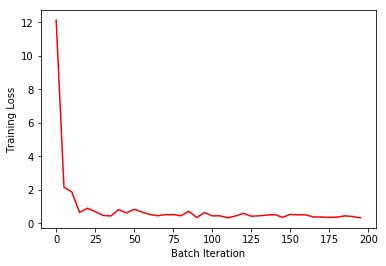

In [106]:
import matplotlib.pyplot as plt
#lloss = [226.7440,85.4669,36.4343,13.0054,15.5587,11.9392,6.4883,3.4751,4.5589,3.2940,2.2241,2.5358,2.9547,1.6141,1.7684,2.2260,1.9281,1.5254,1.8769,1.7149,1.1389,1.4623,2.2930,1.2788,1.2584,2.1135,1.9711,0.8719,2.3196,1.3687,1.3753,1.3103,0.8149,0.7651,1.7740,0.8306,0.9019,0.5104,0.5458,0.9973]
lloss = [12.1194,2.1481,1.8680,0.6402,0.8914,0.6949,0.4631,0.4281,0.8112,0.6108,0.8303,0.6601,0.5160,0.4429,0.5097,0.5132,0.4438,0.7127,0.3345,0.6316,0.4373,0.4390,0.3215,0.4320,0.5834,0.4152,0.4387,0.4835,0.5142,0.3479,0.5260,0.4975,0.4927,0.3684,0.3698,0.3411,0.3636,0.4347,0.3988,0.3137]
plt.plot([x*5 for x in range(len(lloss))], lloss,'r-')
plt.xlabel('Batch Iteration')
plt.ylabel('Training Loss')
plt.show()